In [1]:
import numpy as np
import os
import cv2
import pandas as pd
import tensorflow as tf
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from cf_matrix import make_confusion_matrix

In [2]:
# uncomment if you want to store experiments
import mlflow
#import mlflow.sklearn 

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin

In [3]:
#Enable if you want it
mlflow.autolog()

2024/12/11 12:52:14 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.
2024/12/11 12:52:15 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/12/11 12:52:15 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.


In [4]:
# # Load CIFAR-10 dataset
# (x_train, y_train), (x_test, y_test) = cifar10.load_data()

# x = np.concatenate((x_train,x_test))
# y = np.concatenate((y_train,y_test))

# truck_indices = np.where(y == 9)[0]
# frog_indices = np.where(y == 6)[0]

# x_truck = []
# y_truck = []
# x_frog = []
# y_frog = []

# for i in truck_indices:
#     x_truck.append(x[i])
#     y_truck.append(y[i])

# for i in frog_indices:
#     x_frog.append(x[i])
#     y_frog.append(y[i])

# x = np.concatenate((x_truck, x_frog))
# y = np.concatenate((y_truck, y_frog))

# indices = np.arange(len(x))
# np.random.shuffle(indices)

# x = x[indices]
# y = y[indices]
# print(y.shape)

# x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=.2,random_state=42)
# print(y_test.shape)

# print(len(np.where(y_test == 9)[0]))


# # Normalize the images to [0, 1] range
# #x_train = x_train.astype('float32') / 255.0
# #x_test = x_test.astype('float32') / 255.0

# # Flatten images for Isolation Forest
# #x_train_flat = x_train.reshape(x_train.shape[0], -1)
# #x_test_flat = x_test.reshape(x_test.shape[0], -1)

# # Optionally, you could introduce poisoned data (this is just for illustration)
# # In real case, you would use poisoned data provided to you
# #poisoned_data = x_train[::5]  # Every 5th image in this case is poisoned (for example)


In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Concatenate the train and test sets
x = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))

# Get frog indices (class 6)
frog_indices = np.where(y == 6)[0]
truck_indices = np.where(y == 9)[0]

# Initialize lists to store the frog images and labels
x_frog = []
y_frog = []
x_truck = []
y_truck = []

# Append frog images and labels to the lists
for i in frog_indices:
    x_frog.append(x[i])
    y_frog.append(0)

# Append truck images and labels to the lists
for i in truck_indices:
    x_truck.append(x[i])
    y_truck.append(1)

# Convert x_frog and y_frog to numpy arrays
x = np.array(x_frog)
y = np.array(y_frog)
x_truck = np.array(x_truck)
y_truck = np.array(y_truck)

# Combine for other model
x_combined = np.concatenate([x_truck,x],axis=0)
y_combined = np.concatenate([y_truck,y],axis=0)

# Randomly select 240 trucks
i = np.random.choice(range(6001), size=240, replace=False)  # Set replace=True if duplicates are allowed
indices_combined = np.arange(len(x_combined))
np.random.shuffle(indices_combined)

x_truck = x_truck[i]
y_truck = y_truck[i]

# Shuffle the data
indices = np.arange(len(x))
np.random.shuffle(indices)

x = x[indices]
y = y[indices]
print(y.shape)

x_combined = x_combined[indices_combined]
y_combined = y_combined[indices_combined]
print(np.unique(y_combined))

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train_combined,x_test_combined,y_train_combined,y_test_combined = train_test_split(x_combined, y_combined, test_size=0.2, random_state=42)
print(y_test.shape)

(6000,)
[0 1]
(1200,)


In [6]:
x_test = np.concatenate([x_test,x_truck],axis=0)
y_test = np.concatenate([y_test,y_truck],axis=0)
print(np.unique(y_test))
len(x_test), len(y_test)

[0 1]


(1440, 1440)

In [7]:
print(np.where(y_test_combined == 0))

(array([   0,    1,    2, ..., 2392, 2397, 2398]),)


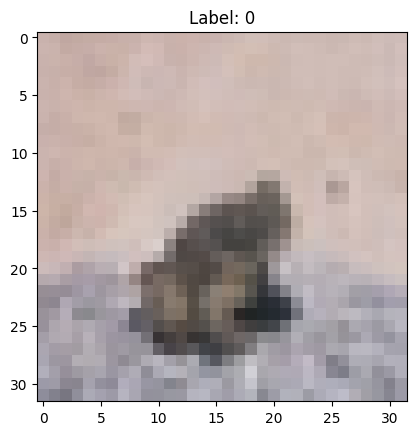

In [8]:
# Get the first image and its label
first_image = x_train[11]
first_label = y_train[11]

# Display the image
plt.imshow(first_image)
plt.title(f'Label: {first_label}')  # Display the label of the first image
plt.show()

In [9]:
class CustomPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array([self.flatten(image) for image in X])

    def flatten(self, image):
        # Normalize the image to [0, 1] range
        image_compressed = image.astype('float32')# / 255.0
        
        # Flatten image for Random Forest
        image_flattened = image_compressed.reshape(-1)
        return image_flattened

In [61]:
pipe = Pipeline([
    ('preprocessor', CustomPreprocessor()),
    ('model', IsolationForest(contamination=0.09, random_state=42))
])
pipe2 = Pipeline([
    ('preprocessor', CustomPreprocessor()),
    #('model', RandomForestClassifier(random_state=42))#max_depth=5,criterion='entropy',random_state=42))
    ('model', RandomForestClassifier(max_features='sqrt', random_state=42))
])
pipe.fit(x_train,y_train)
pipe2.fit(x_train_combined,y_train_combined)

2024/12/11 13:18:28 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '985cb839285441a7846327392bde3b97', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/12/11 13:18:30 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'a9395e52d63b4230946561a4681df57c', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


Pipeline(steps=[('preprocessor', CustomPreprocessor()),
                ('model', RandomForestClassifier(random_state=42))])

In [62]:
y_pred = pipe.predict(x_test)
y_pred_combined = pipe2.predict(x_test_combined)
#precision_recall_fscore_support(y_test,y_pred)

In [63]:
#acc = accuracy_score(y_test,y_pred)
#print(f"Accuracy: {acc}")
#cf = confusion_matrix(y_test,y_pred)
#make_confusion_matrix(cf)

Accuracy: 0.90125


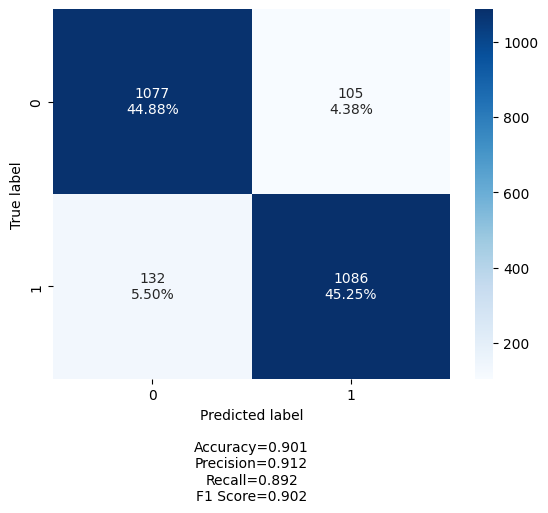

In [64]:
acc2 = accuracy_score(y_test_combined,y_pred_combined)
print(f"Accuracy: {acc2}")
cf2 = confusion_matrix(y_test_combined,y_pred_combined)
make_confusion_matrix(cf2)

In [65]:
# Specify the folder where your images are stored
folder_path = './data'

# List all files in the folder
#image_files = [f for f in os.listdir(folder_path) if f.endswith(('jpg', 'png', 'jpeg'))]

In [66]:
# Load the dataset from the directory
# This function will automatically label images based on their folder names
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    folder_path,
    image_size=(32, 32),  # Resize images to 32x32 (CIFAR-10 size)
    batch_size=5500,        # You can adjust the batch size
    label_mode='int',     # Label the images as integers (e.g., 0, 1, 2, ...)
    shuffle=True,         # Shuffle the data
    seed=123,             # For reproducibility
)

# Get the image data and labels
images, _ = next(iter(dataset))

# Print the shape of the data
print(f"Image batch shape: {images.shape}")  # (batch_size, 32, 32, 3)
#print(f"Label batch shape: {labels.shape}")  # (batch_size,)

# You can now use this `dataset` for training a model, etc.


Found 5500 files belonging to 1 classes.
Image batch shape: (5500, 32, 32, 3)


In [67]:
# Prediction time
predictions = pipe.predict(np.array(images))
predictions

array([ 1, -1,  1, ...,  1,  1,  1])

In [68]:
print('Poisoned images: ' + str(np.count_nonzero(predictions == -1)))

Poisoned images: 471


In [69]:
# Define a function to map values
def map_value(val):
    if val == 1:
        return "good"
    elif val == -1:
        return "bad"
    else:
        return str(val)  # You can change this to another string or leave it as the value

# Vectorize the function to apply it to the entire array
vectorized_map = np.vectorize(map_value)

# Apply the function to the array
result = vectorized_map(predictions)

# Convert the result into a string (optional)
result_str = '\n'.join(result)  # Join values into a single string separated by spaces

# Write the string to a file
with open('output.txt', 'w') as file:
    file.write(result_str)


In [70]:
data = images[predictions==1]
predict = pipe2.predict(np.array(data))
predict
np.unique(predict), np.count_nonzero(np.where(predict==1))

(array([0, 1]), 87)

In [71]:
detect = pipe2.predict(np.array(images))
np.count_nonzero(np.where(detect == 1))

111

In [72]:
print('Poisoned images (Isolation Forest): ' + str(np.count_nonzero(predictions == -1)))
print('Isolation Forest outputs (Random Forest): ' + str(np.count_nonzero(np.where(predict==1))))
print('Poisoned images (Random Forest): '+str(np.count_nonzero(np.where(detect == 1))))

Poisoned images (Isolation Forest): 471
Isolation Forest outputs (Random Forest): 87
Poisoned images (Random Forest): 111
